In [1]:
# Base utilities
import os

# Data Mining
import math
import random
random_state = 42
random.seed(random_state)
seed=random_state
import numpy as np
import pandas as pd
import geopandas as gpd
# import osmnx as ox
# import pandana as pdn
import pickle as pkl
import folium

import shap

# Plot
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import seaborn as sns

# Learning
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, train_test_split, KFold

# Models
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Directories
for d in ["data", "models", "logs", "results"]:
    if not os.path.isdir(d):
        os.mkdir(d)


from sklearn.model_selection import GroupKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from itertools import cycle
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as patches

c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read
trips = pd.read_csv(f"results/trips_pre_model.csv",index_col=0)
# trips = pd.read_csv('/content/drive/MyDrive/Mobility_Choice/model/results/trips_pre_model.csv',index_col=0)
replacement_dict = {'Andando': 'Walk'}
trips['Modo'] = trips['Modo'].replace(replacement_dict)
trips

,Modo,Hora_Ini_E,Dur_Tot,Per_hog,Turismos,Sexo,Edad,crnt_tur,Group,O_lat,...,30%,drive_tt,distance,walk_tt,transit_tt,transit_tt_gm,gm_ua,Tipo_familia,Mun_Ori,Mun_Des
0,Car,109,13.9,2,2,1,6,1,2194,43.315076,...,1,14.314333,7713.093,93.942367,36.442,60.0,0.488542,4,69,69
1,Car,62,15.1,2,2,1,4,1,1651,43.317024,...,1,12.797800,8962.584,145.466050,46.524,51.0,0.091793,2,69,69
2,PT,180,36.1,2,4,2,3,1,2731,43.324474,...,1,10.141033,6449.426,94.093417,30.343,36.0,0.170538,2,69,69
3,Car,198,17.5,3,2,1,5,1,1710,43.323712,...,1,13.098367,6794.456,84.678717,38.993,78.0,0.666826,2,69,69
4,PT,106,10.7,2,1,1,5,1,1646,43.311060,...,1,1.725333,768.076,12.326833,9.184,11.0,0.179945,2,69,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10313,Walk,83,15.4,2,1,1,4,2,347,43.305996,...,1,2.604183,1240.299,15.294017,7.962,18.0,0.773284,2,56,56
10314,Walk,100,5.3,1,2,2,4,1,358,43.307498,...,1,1.201000,495.243,5.661667,4.208,6.0,0.351097,3,56,56
10315,Walk,159,5.0,2,2,2,5,1,359,43.306916,...,1,0.691717,291.519,4.914900,3.656,6.0,0.485501,3,56,56
10316,Walk,93,14.3,1,1,1,2,2,347,43.307285,...,1,1.938700,862.164,14.051100,10.263,18.0,0.547500,2,56,56


# Cross validation

# Train-test with GroupkFold

In [279]:
trips['Modo'].value_counts()

Modo
Car        6008
Andando    2461
PT         1849
Name: count, dtype: int64

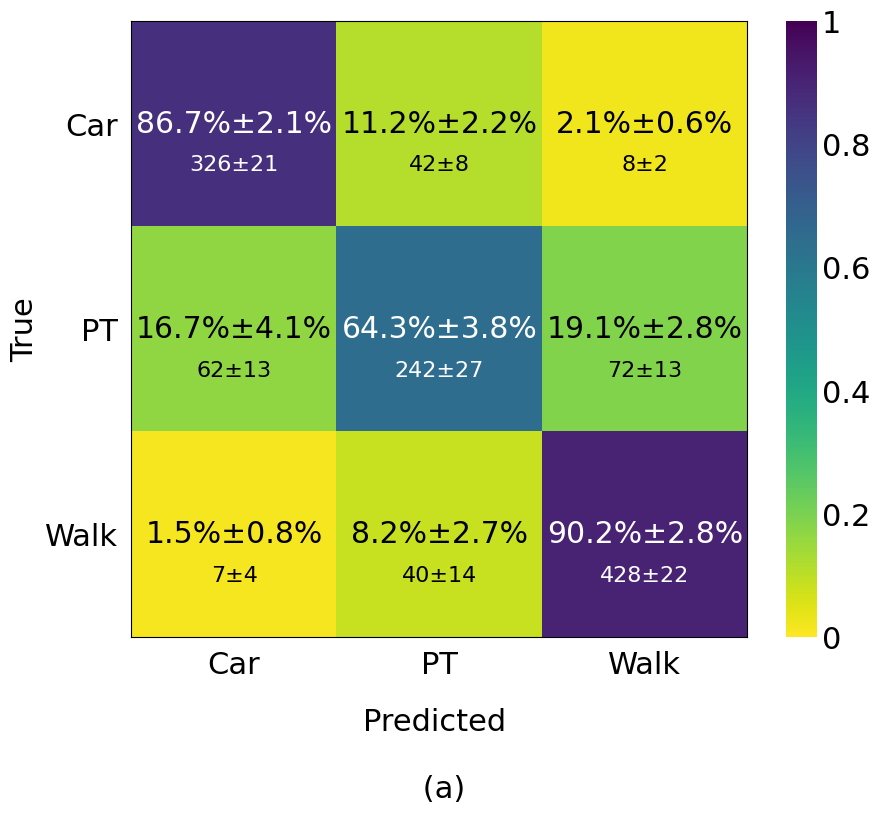

In [179]:
model = RandomForestClassifier(n_estimators=20, random_state=700)
model_name = type(model).__name__

df = trips

# Create 10 different dfs
car_df = df[df['Modo'] == 'Car']
pt_df = df[df['Modo'] == 'PT']
walk_df = df[df['Modo'] == 'Walk']

dfs = []

for _ in range(10):
    sampled_car_df = car_df.sample(n=1849, replace=False)
    new_df = pd.concat([sampled_car_df, pt_df, walk_df])
    new_df = new_df.reset_index(drop=True)
    dfs.append(new_df)

confusion_matrices = []
confusion_matrices_w = []

for df in dfs:
    groups = df['Group']
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
    train_idx, test_idx = next(gss.split(df, groups=groups))
    train_set = df.iloc[train_idx]
    test_set = df.iloc[test_idx]

    X_train = train_set.drop(columns=["Modo", 'Dur_Tot', "Group", "O_lat", "O_long", "D_lat", "D_long", 'times', 'destination_coords', 'chosen_time', '30%', 'transit_tt', 'gm_ua', "Mun_Ori", "Mun_Des"])
    X_test = test_set.drop(columns=["Modo", 'Dur_Tot', "Group", "O_lat", "O_long", "D_lat", "D_long", 'times', 'destination_coords', 'chosen_time', '30%', 'transit_tt', 'gm_ua', "Mun_Ori", "Mun_Des"])
    y_train = np.array(train_set["Modo"])
    y_test = np.array(test_set["Modo"])

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_train)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    confusion_matrices.append(cm_normalized)
    confusion_matrices_w.append(cm)

## SECOND WEIGHTED MEAN AND STD DEV

def calculate_mean_and_std(confusion_matrices, categories):
    # Initialize sum of matrices and sum of squared matrices for variance calculation
    sum_of_matrices = np.zeros((categories, categories), dtype=float)
    sum_of_squares = np.zeros((categories, categories), dtype=float)

    # Sum all confusion matrices and their squares
    for cm in confusion_matrices:
        sum_of_matrices += cm
        sum_of_squares += cm**2

    # Compute simple mean
    n = len(confusion_matrices)
    simple_mean = sum_of_matrices / n

    # Compute variance and then standard deviation
    variance = (sum_of_squares - (sum_of_matrices**2 / n)) / n
    std_deviation = np.sqrt(variance)

    return simple_mean, std_deviation

def get_text_color(value, cmap, threshold=0.5):
    rgba = cmap(value)
    luminance = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
    return 'white' if luminance < threshold else 'black'

def plot_combined_matrix(mean_matrix, std_dev_matrix, title='Combined Mean and Std Dev'):
    cmap = plt.get_cmap('Reds')
    norm = plt.Normalize(vmin=mean_matrix.min(), vmax=mean_matrix.max())
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(mean_matrix, cmap='Reds', interpolation='nearest')
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

    # Label each cell with mean and std deviation
    for (i, j), val in np.ndenumerate(mean_matrix):
        text_color = get_text_color(norm(val), cmap)
        text = f'{val:.2f} ± {std_dev_matrix[i, j]:.2f}'
        ax.text(j, i, text, ha='center', va='center', color=text_color)

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    # plt.show()

# Assuming you have a list of 10 confusion matrices stored in confusion_matrices and each matrix is of shape (3, 3)
categories = 3
mean, std_dev = calculate_mean_and_std(confusion_matrices_w, categories)

# Plot the combined mean and standard deviation
# plot_combined_matrix(mean, std_dev)

## DEFINITIVE

# Convert the list of matrices into a 3D numpy array for easier calculation
confusion_matrices = np.array(confusion_matrices)

# Compute mean and standard deviation across the first axis (the different folds)
mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
std_confusion_matrix = np.std(confusion_matrices, axis=0)

# vmin = np.min(mean_confusion_matrix)
# vmax = np.max(mean_confusion_matrix)
vmin = 0
vmax = 1

fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.cm.viridis_r
cax = ax.matshow(mean_confusion_matrix, cmap=cmap, vmin=vmin, vmax=vmax)
cbar = fig.colorbar(cax)
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_ticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'])
cbar.ax.tick_params(length=0)
cbar.outline.set_visible(False)
cbar.ax.tick_params(labelsize=22)

# for spine in ax.spines.values():
#     spine.set_visible(False)

ax.set_xticks(np.arange(len(label_encoder.classes_)))
ax.set_xticklabels(label_encoder.classes_, rotation=0, ha='center', fontsize=22)
ax.set_yticks(np.arange(len(label_encoder.classes_)))
ax.set_yticklabels(label_encoder.classes_, fontsize=22)
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='major', pad=10)  # Ajusta el padding en el eje x
ax.tick_params(axis='y', which='major', pad=10)
ax.tick_params(axis='both', which='both', length=0)

# Annotating with mean and std values
for (i, j), val in np.ndenumerate(mean_confusion_matrix):
    rgba = cmap((val-vmin)/(vmax-vmin))  # Normalize the value and get RGBA from colormap
    luminance = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]  # Calculate luminance
    text_color = 'white' if luminance < 0.5 else 'black'
    # ax.text(j, i, f"{val:.2%}\n±{std_confusion_matrix[i, j]:.2%}", ha='center', va='center', fontsize=8)
    # Mean value with percentage format
    mean_text = f"{val:.1%}"
    # Standard deviation with percentage format
    std_text = f"±{std_confusion_matrix[i, j]:.1%}"

    mean2 = f"{mean[i, j]:.0f}"
    std2 = f"±{std_dev[i, j]:.0f}"

    # Concatenate mean and standard deviation with space
    # text_label = f"{mean_text}{std_text}\n{mean2}{std2}"
    
    # ax.text(j, i, text_label, ha='center', va='center', fontsize=10, color=text_color)

    # Define texts
    percent_text = f"{mean_text}{std_text}"
    values_text = f"{mean2}{std2}"
    
    # Draw text in two parts with different font sizes
    ax.text(j, i, percent_text, ha='center', va='center', color=text_color, fontsize=21.5)
    ax.text(j, i+0.2, values_text, ha='center', va='center', color=text_color, fontsize=16)

# plt.title('Mean and Std Dev of Normalized Confusion Matrix')
plt.xlabel('Predicted \n\n (a)', fontsize=22, labelpad=20)
plt.ylabel('True', fontsize=22)
plt.show()

## Create the FINAL model

              precision    recall  f1-score   support

         Car       0.81      0.85      0.83       371
          PT       0.69      0.64      0.66       381
        Walk       0.86      0.89      0.87       526

    accuracy                           0.80      1278
   macro avg       0.79      0.79      0.79      1278
weighted avg       0.80      0.80      0.80      1278
 



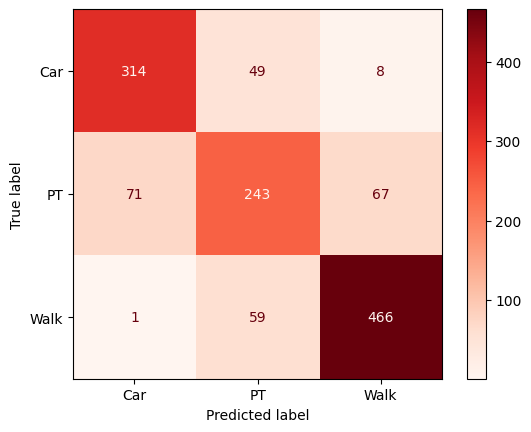

In [5]:
model = RandomForestClassifier(n_estimators=10, random_state=700)
model_name = type(model).__name__

df = trips.copy()
df.rename(columns={'Hora_Ini_E': 'Departure time', 'Per_hog': 'HH size', 'Turismos': 'Nº cars/HH',
                   'Sexo': 'Gender', 'Edad': 'Age', 'crnt_tur': 'Driver\'s license',
                   'drive_tt': 'Car $T_t$', 'distance': 'Distance', 'walk_tt': 'Walk $T_t$',
                   'transit_tt_gm': 'PT $T_t$', 'Tipo_familia': 'Family type'}, inplace=True)

mapeo = {1: 2, 2: 1}
df['Driver\'s license'] = df['Driver\'s license'].map(mapeo)

# Create 10 different dfs
car_df = df[df['Modo'] == 'Car']
pt_df = df[df['Modo'] == 'PT']
walk_df = df[df['Modo'] == 'Walk']

sampled_car_df = car_df.sample(n=1849, replace=False)
df = pd.concat([sampled_car_df, pt_df, walk_df])
df = df.reset_index(drop=True)

groups = df['Group']
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=19)
train_idx, test_idx = next(gss.split(df, groups=groups))
train_set = df.iloc[train_idx]
test_set = df.iloc[test_idx]

X_train = train_set.drop(columns=["Modo", 'Dur_Tot', "Group", "O_lat", "O_long", "D_lat", "D_long", 'times', 'destination_coords', 'chosen_time', '30%', 'transit_tt', 'gm_ua', "Mun_Ori", "Mun_Des"])
X_test = test_set.drop(columns=["Modo", 'Dur_Tot', "Group", "O_lat", "O_long", "D_lat", "D_long", 'times', 'destination_coords', 'chosen_time', '30%', 'transit_tt', 'gm_ua', "Mun_Ori", "Mun_Des"])
y_train = np.array(train_set["Modo"])
y_test = np.array(test_set["Modo"])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_pred),"\n")

    # print("Confusion Matrix\n")
metrics.ConfusionMatrixDisplay.from_predictions(y_test,y_pred,cmap="Reds")

# Save the model
# with open(os.path.join(f"models",'rf_final_1.pkl'), 'wb') as file:
#     pkl.dump(model, file)

# ROC VALUE

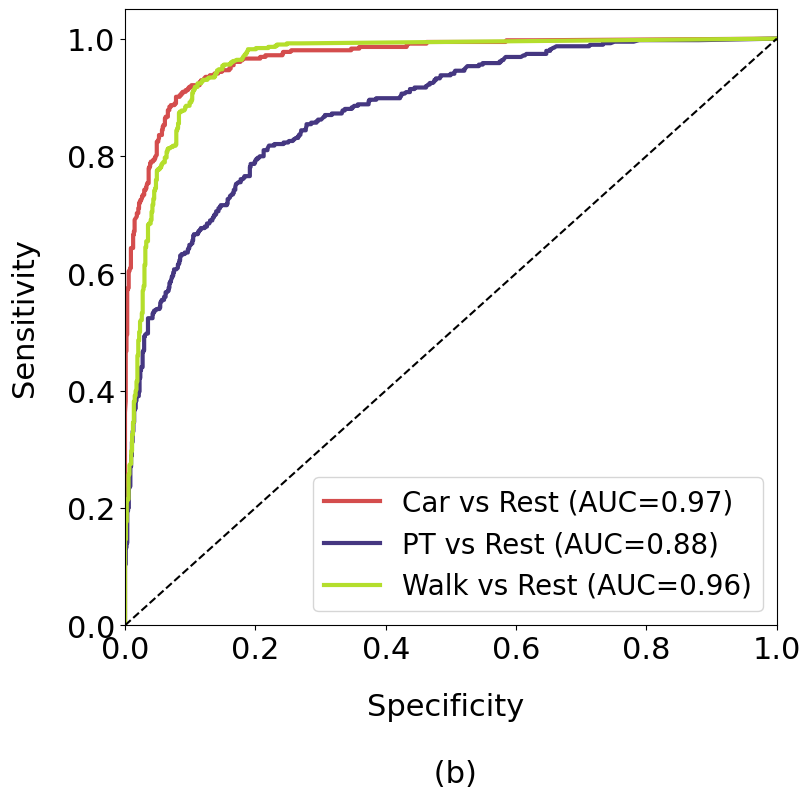

In [95]:
df = trips

label_encoder=LabelEncoder()
label_encoder.fit(y_train)
y=label_encoder.transform(y_train)
classes=label_encoder.classes_

# color_dict = {'Car': 'red', 'Walk': 'green', 'PT': 'blue'}
color_dict = {'Car':  (212/255, 77/255, 77/255), 'Walk': (180/255, 222/255, 44/255), 'PT': (69/255, 55/255, 129/255)}

min_max_scaler=MinMaxScaler()

plt.figure(figsize=(10, 8))
X_train_norm=min_max_scaler.fit_transform(X_train)
X_test_norm=min_max_scaler.fit_transform(X_test)

RF=OneVsRestClassifier(RandomForestClassifier(max_features=7))
RF.fit(X_train_norm,y_train)
y_pred =RF.predict(X_test_norm)
pred_prob = RF.predict_proba(X_test_norm)

y_test_binarized=label_binarize(y_test,classes=np.unique(y_test))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])  
    
    plt.plot(fpr[i], tpr[i], linestyle='-', 
             color=color_dict[classes[i]], label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]), linewidth=3)
    
    
plt.plot([0,1],[0,1],'--', color='black')
# plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_aspect(0.9)
plt.xlim([0,1])
plt.ylim([0,1.05])
# plt.title('Multiclass ROC curve')
plt.xlabel('Specificity \n\n (b)', fontsize=22, labelpad=20)
plt.ylabel('Sensitivity', fontsize=22, labelpad=20)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(loc='lower right', fontsize=20)
plt.show()

# Variable Importance

In [3]:
model_name = "rf_final_1"
file_path = os.path.join("models", f'{model_name}.pkl')

with open(file_path, 'rb') as file:
    model = pkl.load(file)

In [86]:
replacement_dict = {'Car': 0, 'PT': 1, 'Andando': 2}
df['Modo'] = df['Modo'].replace(replacement_dict)

explainer =  shap.Explainer(model)
shap_values = explainer(X_test)
print(np.shape(shap_values.values))

(1278, 11, 3)


In [ ]:
# male = trips[trips['Sexo'] == 1]
# female = trips[trips['Sexo'] == 2]
# male['Modo'].value_counts()
# female['Modo'].value_counts()
# female['Group'].value_counts()
# trips[trips['Group'] == 2174]

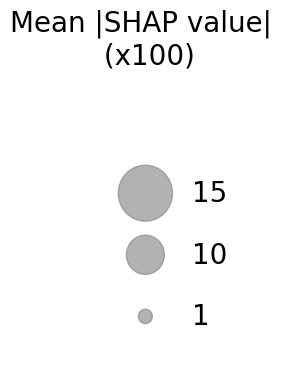

In [156]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

# Values that you want to represent with circles
values = [15, 10, 1]  # Change these values as needed
max_value = max(values)
# radius_factor = 0.07  
radius_factors = [0.07, 0.06, 0.07]

fig, ax = plt.subplots(figsize=(2, 4))  # Adjust figure size as needed
ax.axis('off')

# Calculate normalized sizes for the circles
# sizes = [np.sqrt(value / max_value) * radius_factor for value in values]
sizes = [np.sqrt(value / max_value) * radius for value, radius in zip(values, radius_factors)]

# Plotting the circles
for i, size in enumerate(sizes):
    circle = patches.Ellipse((0.5, 0.6 - i * 0.2), size/0.2, size*2.6, color='grey', alpha=0.6)  # Adjust positions and alpha as needed
    ax.add_patch(circle)
    ax.text(0.8, 0.6 - i * 0.2, str(values[i]), ha='left', va='center', fontsize=20)  # Adjust text settings as needed

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_title("Mean |SHAP value| \n (x100)", fontsize=20, pad=0)  # Adjust fontsize and pad as needed

plt.show()


C:\Users\iazka\AppData\Local\Temp\ipykernel_3368\3356594780.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['-0.3', '-0.15', '0', '0.15', '0.3'])


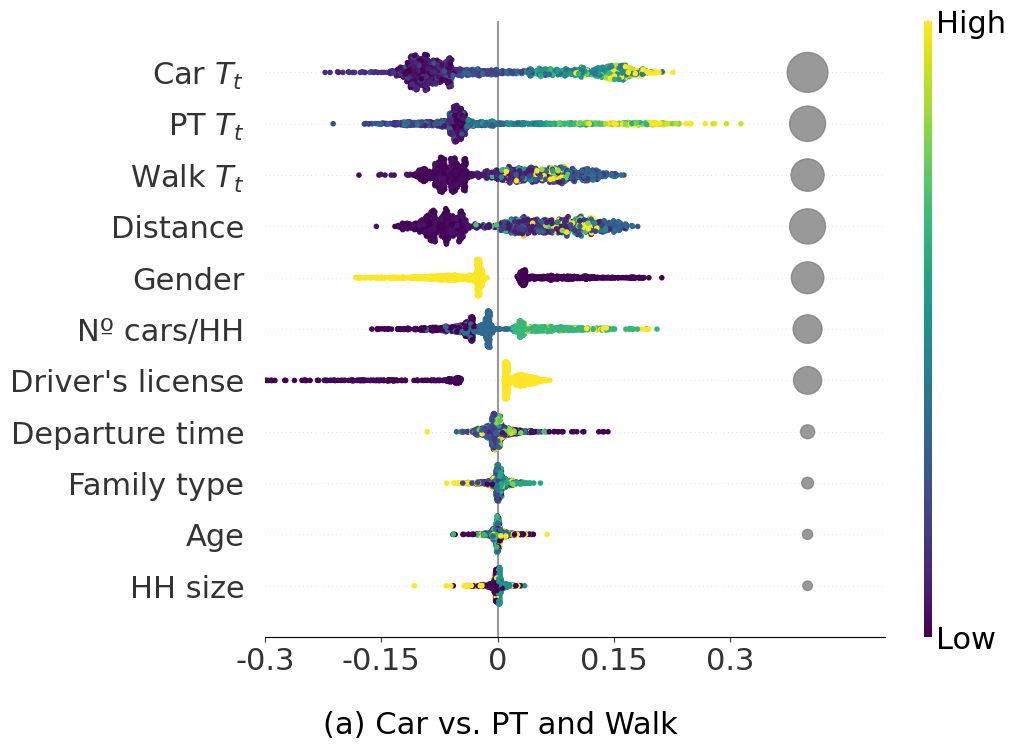

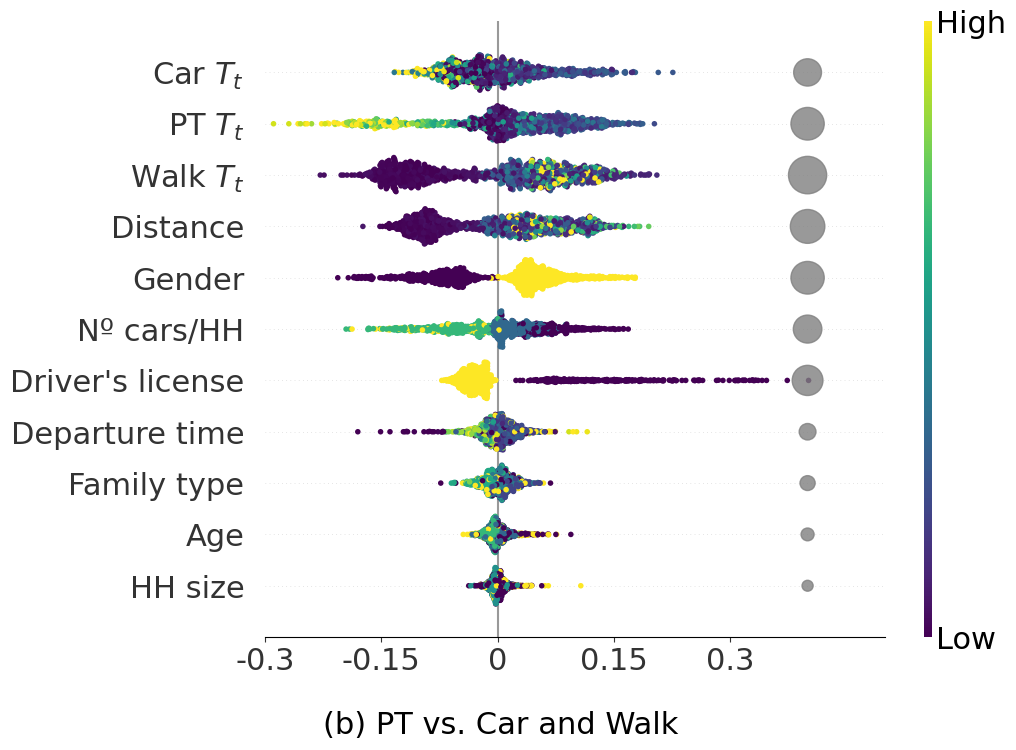

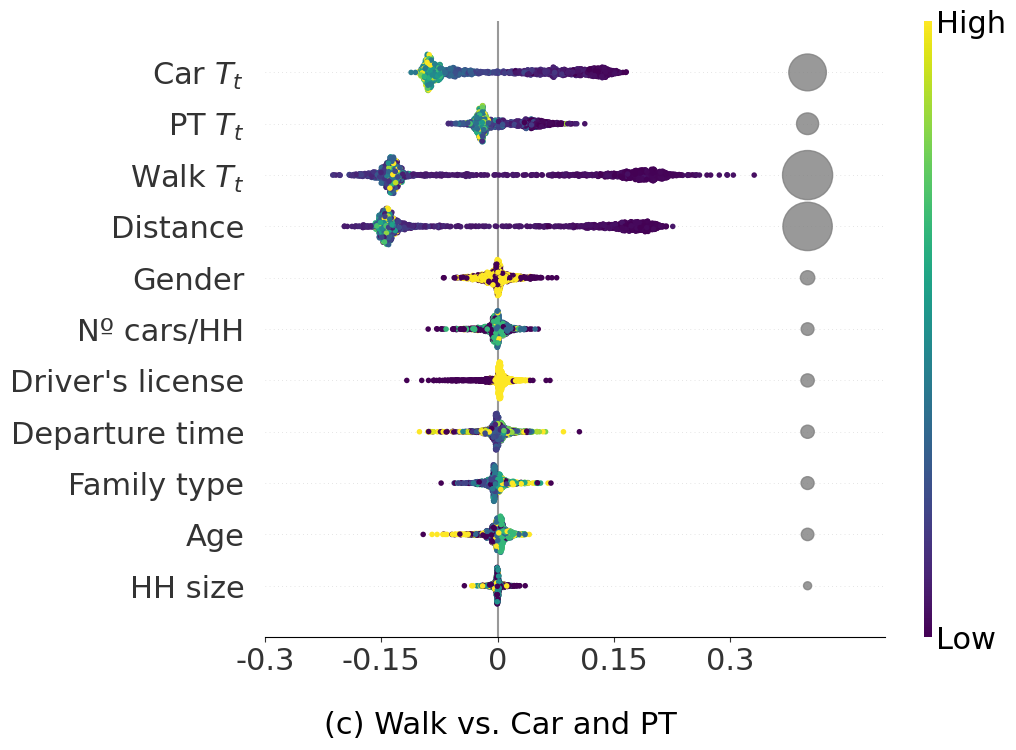

In [138]:
xlabel = ["(a) Car vs. PT and Walk", "(b) PT vs. Car and Walk", "(c) Walk vs. Car and PT"]

# order = ['Car $T_t$', 'PT $T_t$', 'Distance', 'Walk $T_t$', 'Gender', 'Nª car/HH', 'Driver\'s license', 'Departure time', 'Family type', 'Age', 'HH size']
order = [6,9,8,7,3,2,5,0,10,4,1]

default_color = 'viridis'
inverted_color = 'viridis_r'

for i in range(shap_values.values.shape[2]):

    plt.figure(figsize=(14, 16))
    # shap.plots.beeswarm(shap_values[:,:,i], max_display=11, plot_size=[10,8], show=False, color='viridis', order=order)
    # shap.plots.beeswarm(shap.Explanation(values=filtered_shap_values[:,:,i], base_values=shap_values.base_values,
    #                                       data=shap_values.data, feature_names=shap_values.feature_names),
    #                     max_display=11, plot_size=[10,8], show=False, color='viridis', order=order)
    shap.plots.beeswarm(shap_values[:,:,i], max_display=11, plot_size=[10,8], show=False, color='viridis', order=order)

    
    fig, ax = plt.gcf(), plt.gca()

    ax.tick_params(labelsize=22)
    ax.set_xlabel(xlabel[i], fontsize=22, labelpad=20)
    ax.xaxis.set_label_coords(0.38, -0.12)
    # ax.set_xlabel("")
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-1, len(order))
    ax.set_xticklabels(['-0.3', '-0.15', '0', '0.15', '0.3'])
    ax.set_xticks(np.linspace(-0.3, 0.3, 5))
    ax.tick_params(axis='y', which='both', length=0, pad=15) 

    ax2 = ax.twinx()
    ax2.set_xlim(-0.3, 0.5)
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticklabels([])
    ax2.axis('off')

    for spine in ax2.spines.values():
        spine.set_visible(False)

    mean_shap_values = np.mean(np.abs(shap_values.values[:, order, i]), axis=0)[::-1]
    y_positions = np.linspace(start=0, stop=len(order) - 1, num=len(order))

    for idx, mean_val in enumerate(mean_shap_values):
        radius = 1.1*np.sqrt(mean_val  / np.pi)
        circle = patches.Ellipse((0.4, y_positions[idx]), width=radius/3.7, height=radius*4, color='grey', alpha=0.8)
        ax2.add_patch(circle)

    # example_sizes = [0.05, 0.1, 0.2]  # Change these values based on your data
    # labels = ['0.1', '0.2', '0.3']
    # handles = [patches.Ellipse((0, 0), size/3.7, size*4, color='grey', alpha=0.8) for size in example_sizes]
    # # ax.legend(handles, labels, title='Mean |SHAP values|', fontsize=16, title_fontsize=18, loc='upper left')
    # color_bar_ax = fig.axes[-1]  # This assumes the color bar is the last axis added to the figure
    # legend = ax.legend(handles, labels, title='Circle Sizes', fontsize=16, title_fontsize=18, frameon=False,
    #                    bbox_to_anchor=(color_bar_ax.get_position().x1 + 0.05, color_bar_ax.get_position().y1),
    #                    loc='upper left')

    cb_ax = fig.axes[1] 
    cb_ax.tick_params(labelsize=22)
    cb_ax.set_ylabel("")

    plt.show()

C:\Users\iazka\AppData\Local\Temp\ipykernel_3368\1122464281.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['-0.3', '-0.15', '0', '0.15', '0.3'])


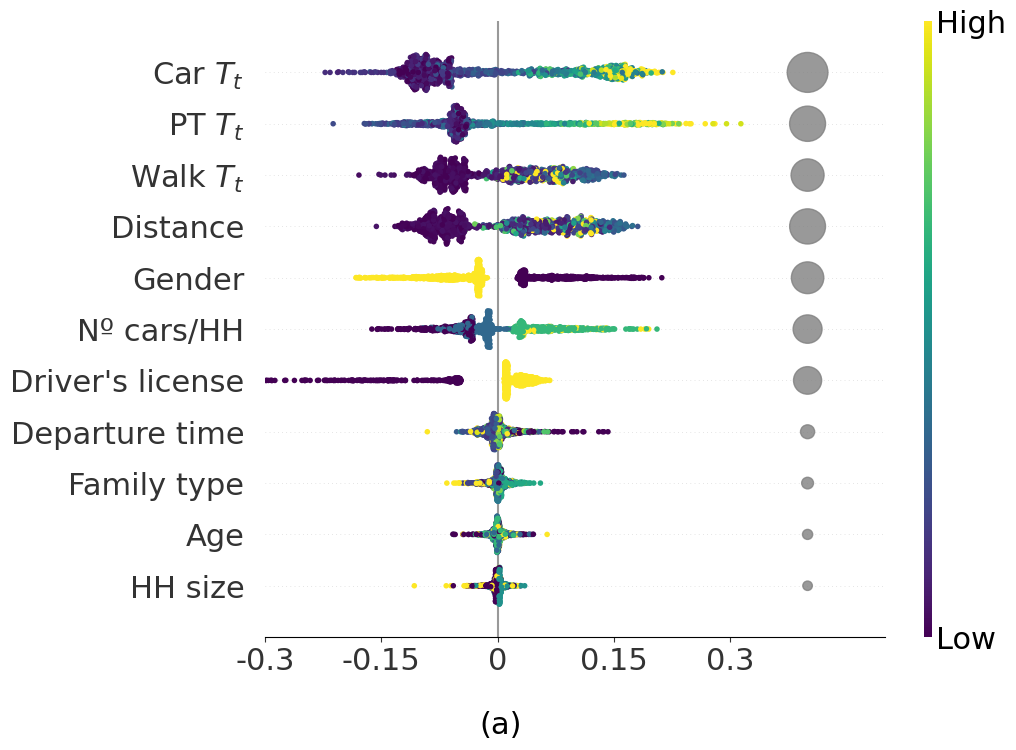

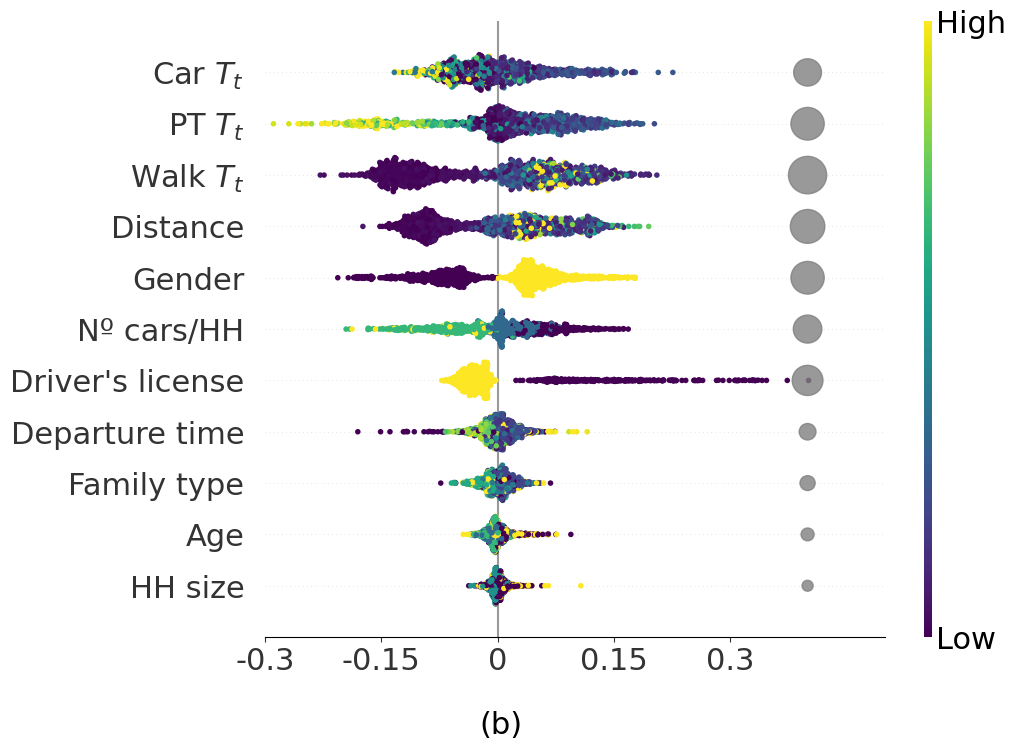

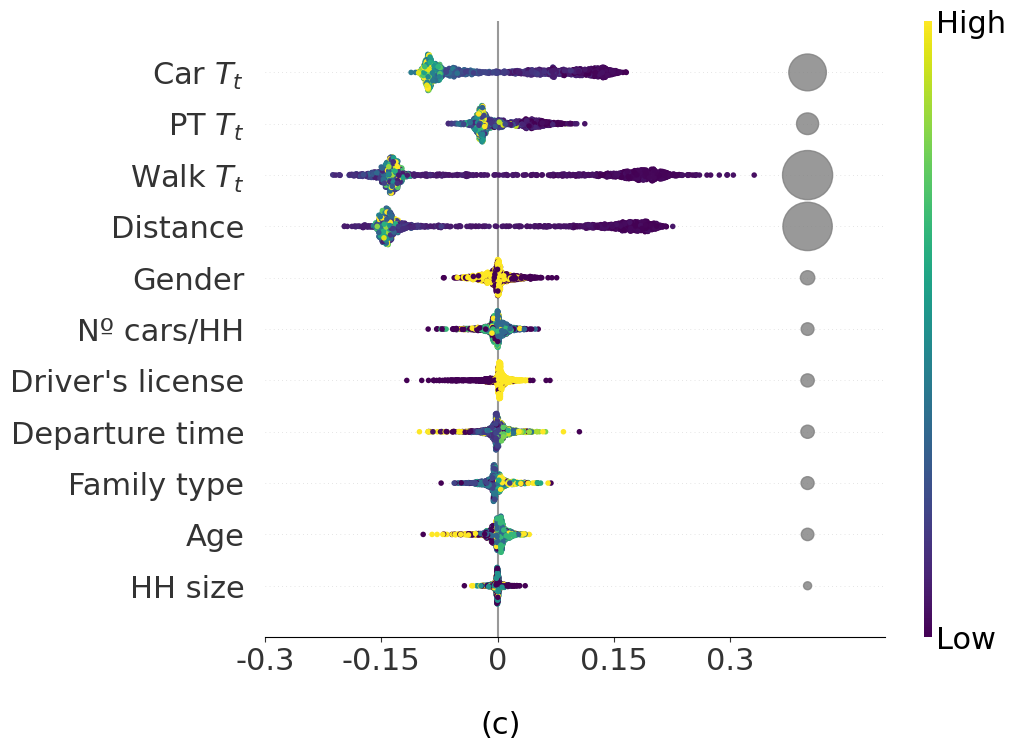

In [74]:
xlabel = ["(a)", "(b)", "(c)"]

# order = ['Car $T_t$', 'PT $T_t$', 'Distance', 'Walk $T_t$', 'Gender', 'Nª car/HH', 'Driver\'s license', 'Departure time', 'Family type', 'Age', 'HH size']
order = [6,9,8,7,3,2,5,0,10,4,1]

default_color = 'viridis'
inverted_color = 'viridis_r'

for i in range(shap_values.values.shape[2]):

    plt.figure(figsize=(14, 16))
    shap.plots.beeswarm(shap_values[:,:,i], max_display=11, plot_size=[10,8], show=False, color='viridis', order=order)
    
    fig, ax = plt.gcf(), plt.gca()

    ax.tick_params(labelsize=22)
    ax.set_xlabel(xlabel[i], fontsize=22, labelpad=20)
    ax.xaxis.set_label_coords(0.38, -0.12)
    # ax.set_xlabel("")
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-1, len(order))
    ax.set_xticklabels(['-0.3', '-0.15', '0', '0.15', '0.3'])
    ax.set_xticks(np.linspace(-0.3, 0.3, 5))
    ax.tick_params(axis='y', which='both', length=0, pad=15) 

    ax2 = ax.twinx()
    ax2.set_xlim(-0.3, 0.5)
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticklabels([])
    ax2.axis('off')

    for spine in ax2.spines.values():
        spine.set_visible(False)

    mean_shap_values = np.mean(np.abs(shap_values.values[:, order, i]), axis=0)[::-1]
    y_positions = np.linspace(start=0, stop=len(order) - 1, num=len(order))

    for idx, mean_val in enumerate(mean_shap_values):
        radius = 1.1*np.sqrt(mean_val  / np.pi)
        circle = patches.Ellipse((0.4, y_positions[idx]), width=radius/3.7, height=radius*4, color='grey', alpha=0.8)
        ax2.add_patch(circle)

    cb_ax = fig.axes[1] 
    cb_ax.tick_params(labelsize=22)
    cb_ax.set_ylabel("")

    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shap  # Make sure SHAP is imported

titles = ["Car", "PT", "Walk"]
order = [6, 9, 7, 8, 3, 2, 5, 0, 10, 4, 1]

# Create and show the SHAP beeswarm plots for each feature set
for i in range(shap_values.values.shape[2]):
    shap.plots.beeswarm(shap_values[:, :, i], max_display=11, plot_size=[10, 8], color='viridis', order=order)
    plt.title(titles[i])
    plt.show()

# Determine the mean SHAP values for all features across all feature sets
mean_shap_values_all = np.abs(np.mean(shap_values.values[:, :, :], axis=0))

# Calculate the max and min for scaling the circle sizes consistently
max_shap = np.sqrt(mean_shap_values_all.max() / np.pi)
min_shap = np.sqrt(mean_shap_values_all.min() / np.pi)

# Now create a separate figure for the circles
fig, ax = plt.subplots(figsize=(2, 8))  # This figure size should match the vertical space of the beeswarm plots

for idx, feature in enumerate(order):
    # Calculate the circle size, scaled between the min and max SHAP values
    mean_val = mean_shap_values_all[feature]
    scaled_radius = np.sqrt(mean_val / np.pi)  # Scale the radius relative to the value
    # Normalize the radius to lie between 0.05 and 0.2 for visibility
    normalized_radius = 0.05 + 0.15 * (scaled_radius - min_shap) / (max_shap - min_shap)
    
    # Add a circle for each feature
    circle = patches.Circle((0.5, idx), normalized_radius, color='orange', alpha=0.5)
    ax.add_patch(circle)

# Set y-limits to match the number of features, x-limits to contain the circles
ax.set_ylim(-1, len(order))
ax.set_xlim(0, 1)
ax.axis('off')  # Hide the axis

plt.show()

C:\Users\iazka\AppData\Local\Temp\ipykernel_3368\1022544506.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['-0.3', '-0.15', '0', '0.15', '0.3'])


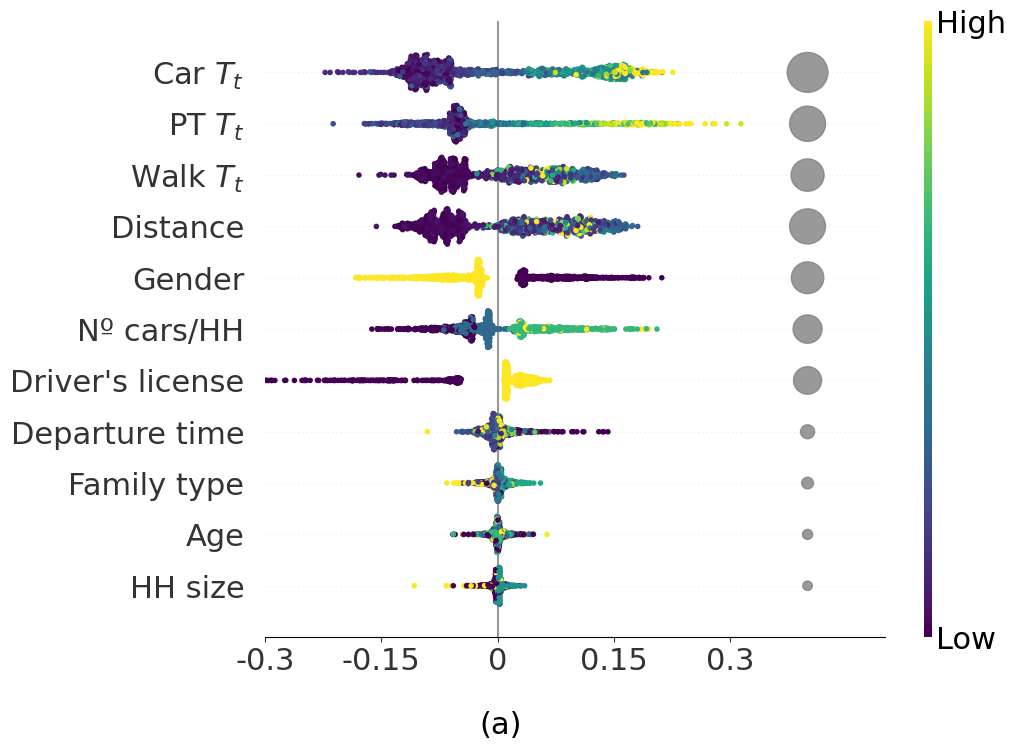

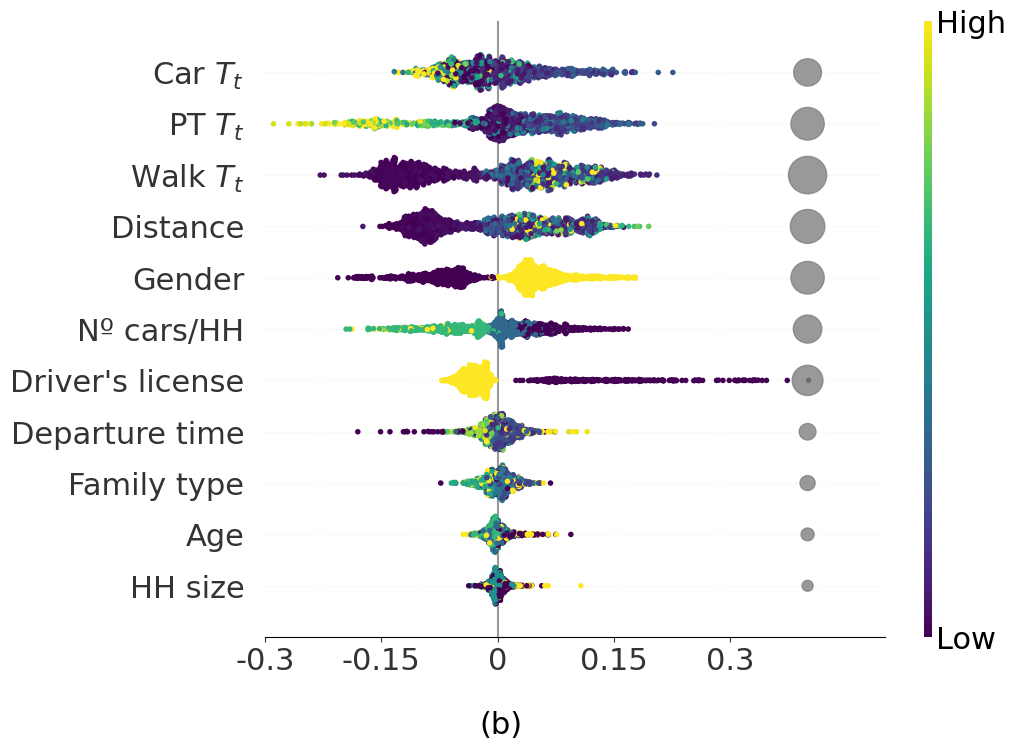

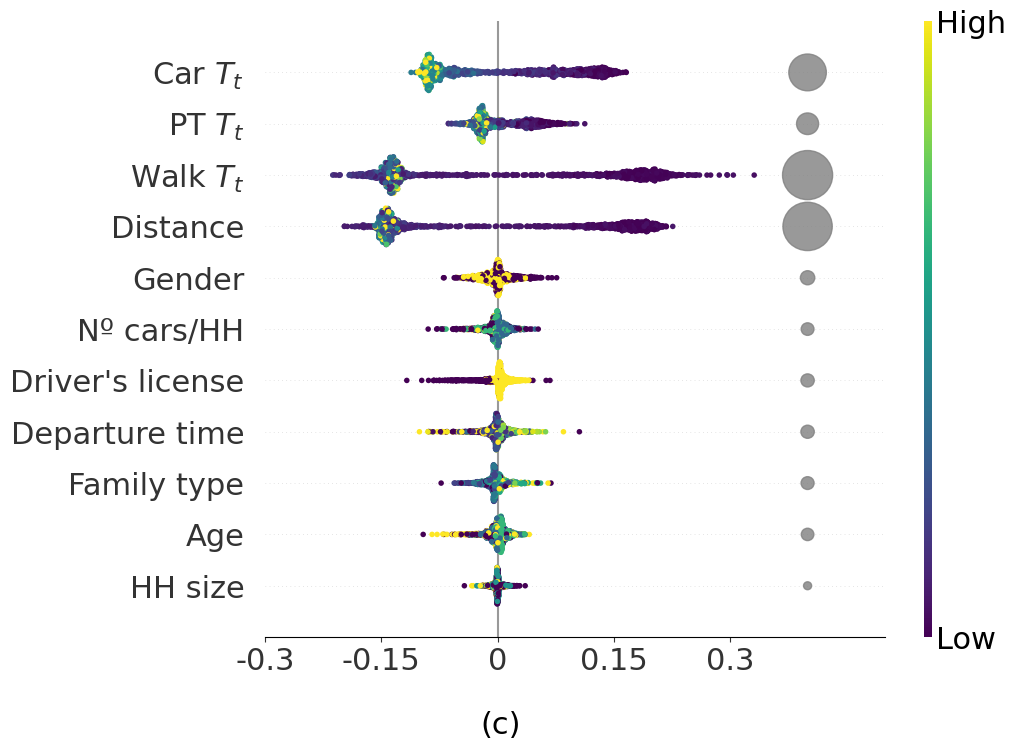

In [57]:
titles = ["(a)", "(b)", "(c)"]
# xlabel = ["SHAP value for Car", "SHAP value for PT", "SHAP value for Walk"]
xlabel = ["(a)", "(b)", "(c)"]

# order = ['Car $T_t$', 'PT $T_t$', 'Distance', 'Walk $T_t$', 'Gender', 'Nª car/HH', 'Driver\'s license', 'Departure time', 'Family type', 'Age', 'HH size']
order = [6,9,8,7,3,2,5,0,10,4,1]

default_color = 'viridis'
inverted_color = 'viridis_r'

for i in range(shap_values.values.shape[2]):

    plt.figure(figsize=(14, 16))
    # shap.plots.beeswarm(shap_values[:,:,i], max_display=11, plot_size=[10,8], show=False, color='viridis', order=order, color_bar=None)
    # color_map = inverted_color if i == 1 else default_color
    shap.plots.beeswarm(shap_values[:,:,i], max_display=11, plot_size=[10,8], show=False, color='viridis', order=order)
    
    fig, ax = plt.gcf(), plt.gca()
    # fig, ax = plt.subplots()

    ax.tick_params(labelsize=22)
    # ax.set_xlabel("SHAP value", fontsize=22, labelpad=20)
    ax.set_xlabel(xlabel[i], fontsize=22, labelpad=20)
    ax.xaxis.set_label_coords(0.38, -0.12)
    # ax.set_xlabel("")
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-1, len(order))
    # ax.set_xticks([-0.3, -0.15, 0, 0.15, 0.3])
    ax.set_xticklabels(['-0.3', '-0.15', '0', '0.15', '0.3'])
    ax.set_xticks(np.linspace(-0.3, 0.3, 5))
    ax.tick_params(axis='y', which='both', length=0, pad=15) 
    # Removing the frame
    # for spine in ax.spines.values():
    #     spine.set_visible(False)

    ax2 = ax.twinx()
    ax2.set_xlim(-0.3, 0.5)
    # ax2.set_xlim(ax.get_xlim())
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticklabels([])
    # ax2.set_xticks(None)
    ax2.axis('off')
    # ax2.set_xticks([0.5, 0.6, 0.7])
    # ax2.set_xticklabels(['Low', 'Medium', 'High'], fontsize=22)  # Example labels
    # ax2.set_yticks([])  # Hide y-ticks on secondary axis
    # ax2.set_xlabel(xlabel[i], fontsize=22, labelpad=20)

    # ax2 = ax.twinx()
    # ax2.set_xlim(-0.3, 0.5)  # Only used to place circles
    # ax2.set_ylim(ax.get_ylim())
    # ax2.axis('off')  # Turn off axis markings
    # ax2.set_aspect('equal', adjustable='datalim')

    for spine in ax2.spines.values():
        spine.set_visible(False)

    # ax.set_title(titles[i], fontsize=50, pad=40)

    mean_shap_values = np.mean(np.abs(shap_values.values[:, order, i]), axis=0)[::-1]
    y_positions = np.linspace(start=0, stop=len(order) - 1, num=len(order))  # adjust according to the number of features shown
    
    # for idx, mean_val in enumerate(mean_shap_values):
    #     ax.text(0.32, y_positions[idx], f"{mean_val:.2f}", fontsize=22, va='center')

    for idx, mean_val in enumerate(mean_shap_values):
        radius = 1.1*np.sqrt(mean_val  / np.pi)
        circle = patches.Ellipse((0.4, y_positions[idx]), width=radius/3.7, height=radius*4, color='grey', alpha=0.8)  # Positioned at center of ax2
        ax2.add_patch(circle)

    cb_ax = fig.axes[1] 
    cb_ax.tick_params(labelsize=22)
    # cb_ax.set_ylabel("Feature value", fontsize=22)
    cb_ax.set_ylabel("")

    # fig.savefig("myfigure.svg", format='SVG')
    plt.show()

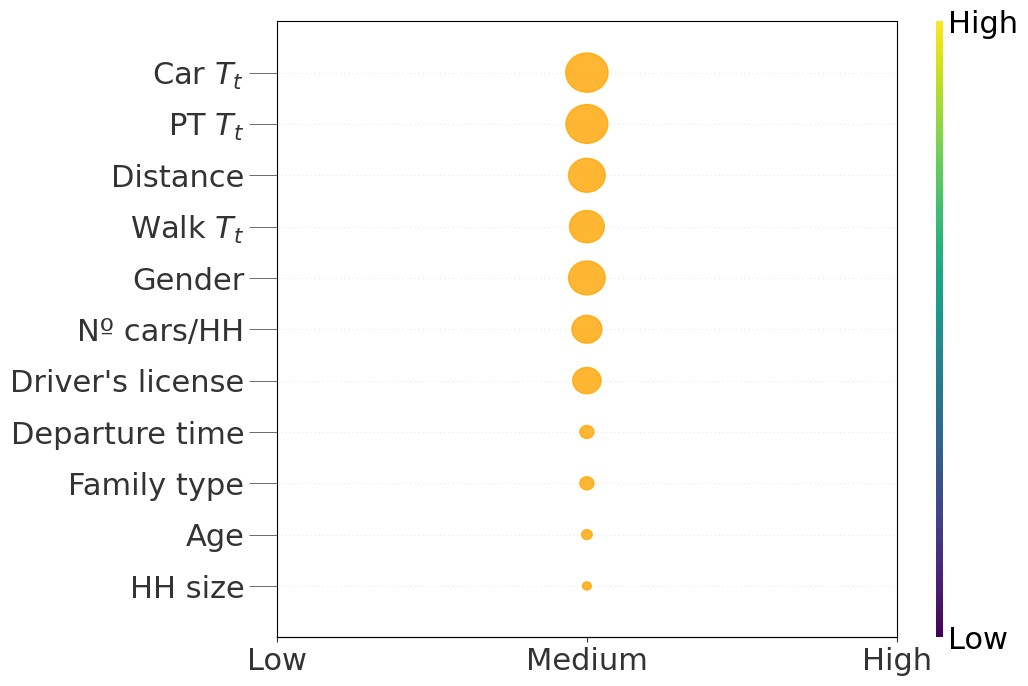

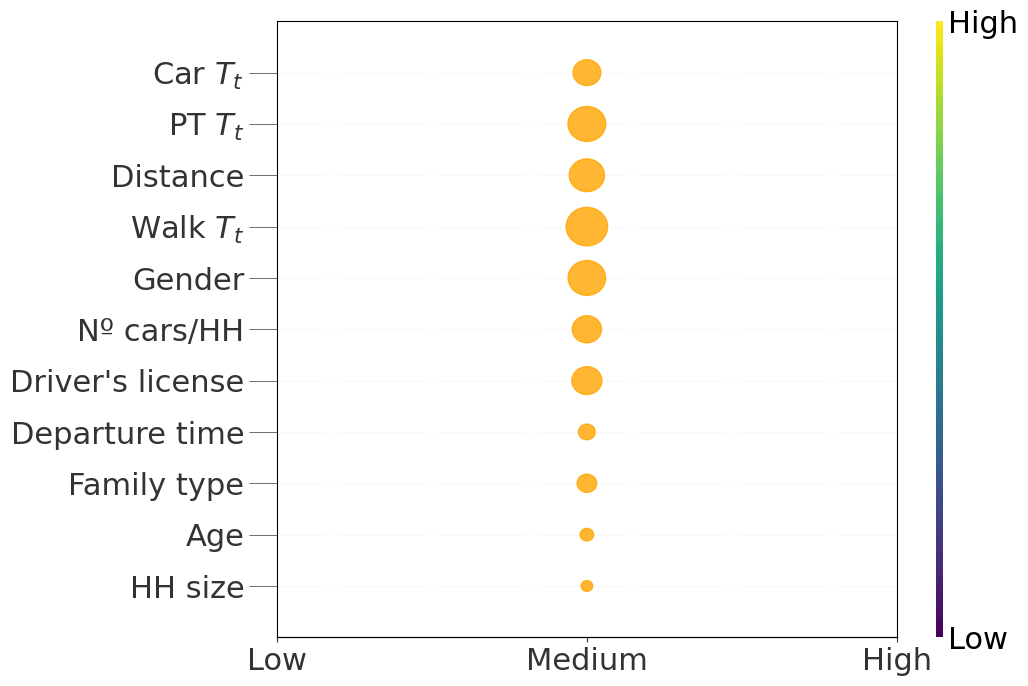

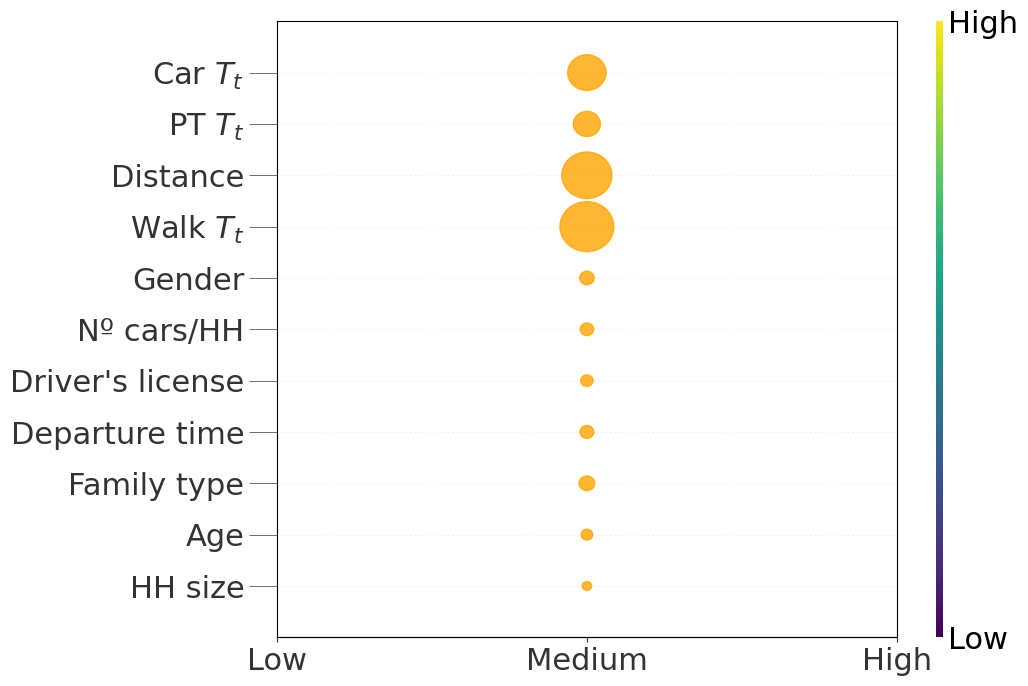

In [494]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import shap  # Assuming SHAP library is already imported

titles = ["Car", "PT", "Walk"]
xlabel = ["SHAP value for Car", "SHAP value for PT", "SHAP value for Walk"]
order = [6, 9, 7, 8, 3, 2, 5, 0, 10, 4, 1]

for i in range(shap_values.values.shape[2]):
    shap.plots.beeswarm(shap_values[:, :, i], max_display=11, plot_size=[10, 8], show=False, color='viridis', order=order)

    fig, ax = plt.gcf(), plt.gca()
    ax.tick_params(labelsize=22)
    ax.set_xlabel("")
    ax.set_xlim(-0.3, 0.5)
    ax.set_ylim(-1, len(order))
    ax.set_xticks([-0.3, -0.15, 0, 0.15, 0.3])
    ax.set_xticklabels(['-0.3', '-0.15', '0', '0.15', '0.3'])

    # Create a secondary axis for each subplot
    ax2 = ax.twinx()
    ax2.set_xlim(0.5, 0.7)  # Set limits for the additional x-axis to the right
    ax2.set_ylim(ax.get_ylim())
    ax2.set_xticks([0.5, 0.6, 0.7])
    ax2.set_xticklabels(['Low', 'Medium', 'High'], fontsize=22)  # Example labels
    ax2.set_yticks([])  # Hide y-ticks on secondary axis
    ax2.set_xlabel(xlabel[i], fontsize=22, labelpad=20)

    mean_shap_values = np.mean(np.abs(shap_values.values[:, order, i]), axis=0)[::-1]
    y_positions = np.linspace(start=0, stop=len(order) - 1, num=len(order))

    for idx, mean_val in enumerate(mean_shap_values):
        radius = 1.1 * np.sqrt(mean_val / np.pi)
        circle = patches.Ellipse((0.6, y_positions[idx]), width=radius / 14, height=radius * 4, color='grey', alpha=0.8)
        ax2.add_patch(circle)  # Add circles on the secondary axis

    cb_ax = fig.axes[1]
    cb_ax.tick_params(labelsize=22)
    cb_ax.set_ylabel("Feature value", fontsize=22)
    cb_ax.set_ylabel("")

    plt.show()


In [360]:
mean_shap_values

array([0.00322021, 0.00525778, 0.00550351, 0.00932086, 0.00473648,
       0.00923241, 0.01020132, 0.11079679, 0.09130548, 0.03544262,
       0.09464193])

In [91]:
model.predict_proba(X_test)[0]

array([0.  , 0.85, 0.15])

In [ ]:
# Graphs for first instance, all features and each class
# shap.plots.waterfall(shap_values[0, :, 0])
# shap.plots.waterfall(shap_values[0, :, 1])
# shap.plots.waterfall(shap_values[0, :, 2])

In [94]:
mean_0 = np.mean(np.abs(shap_values.values[:, :, 0]), axis=0)
mean_1 = np.mean(np.abs(shap_values.values[:, :, 1]), axis=0)
mean_2 = np.mean(np.abs(shap_values.values[:, :, 2]), axis=0)

In [95]:
shap.plots.waterfall(mean_0)
# shap.plots.waterfall(shap_values[0, :, 1])
# shap.plots.waterfall(shap_values[0, :, 2])

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

In [141]:
mean_0.sort()
mean_0

array([0.00541776, 0.0061681 , 0.0082995 , 0.01182762, 0.04674483,
       0.04958672, 0.0621351 , 0.0644056 , 0.07608714, 0.07648335,
       0.09812358])

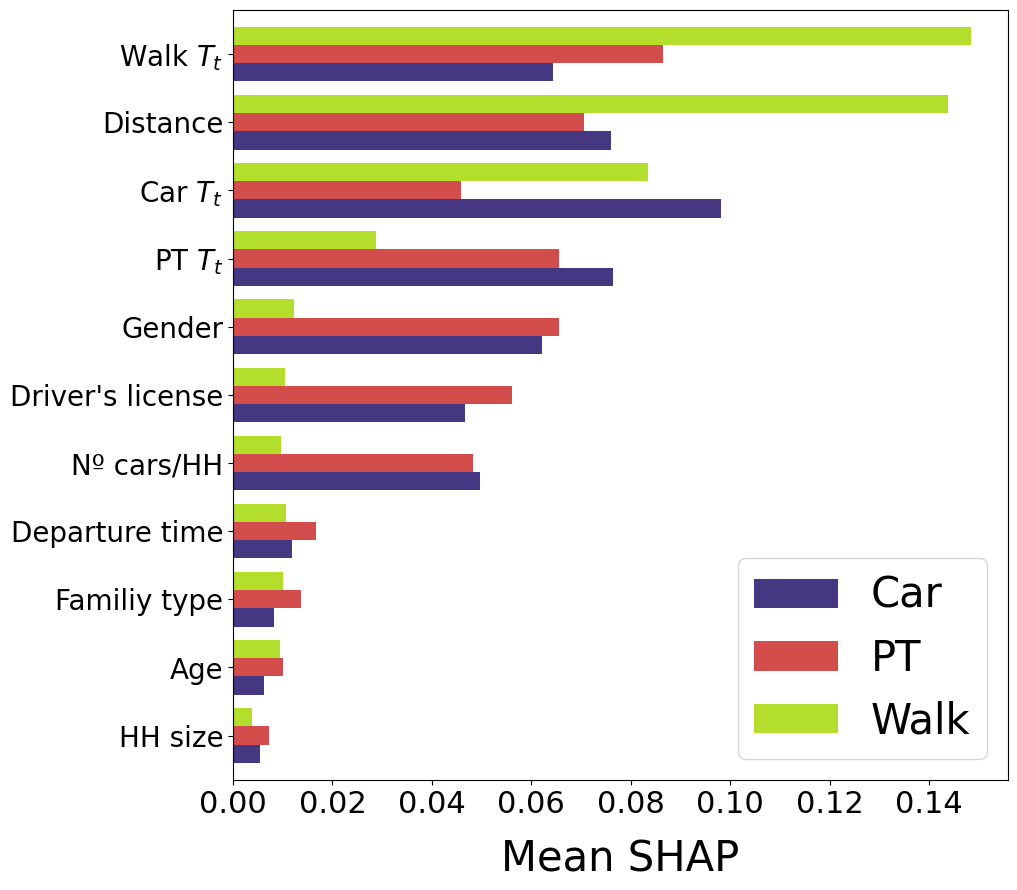

In [135]:
mean_0 = np.mean(np.abs(shap_values.values[:, :, 0]), axis=0)
mean_1 = np.mean(np.abs(shap_values.values[:, :, 1]), axis=0)
mean_2 = np.mean(np.abs(shap_values.values[:, :, 2]), axis=0)

df_shap = pd.DataFrame({'Car': mean_0, 'PT': mean_1, 'Walk': mean_2})
# df_shap = pd.DataFrame({0: mean_0, 1: mean_1, 2: mean_2})

# Ordenar
df_shap['Total'] = df_shap.sum(axis=1)
df_shap_sorted = df_shap.sort_values(by='Total', ascending=True)
df_shap_sorted = df_shap_sorted.drop(columns=['Total'])

variables = ['Departure time', 'HH size', 'Nº cars/HH', 'Gender', 'Age', 'Driver\'s license', 'Car $T_t$', 'Distance', 'Walk $T_t$', 'PT $T_t$', 'Familiy type']
aux = pd.DataFrame({
    'Feature': variables,
    'Value': df_shap['Total']
})
aux_sorted = aux.sort_values(by='Value', ascending=True)
variables_final = aux_sorted['Feature']

# colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
colors = ['red', 'blue', 'green']
colors = [(0.839, 0.152, 0.156), (0.1, 0.3, 0.999), (0.172, 0.627, 0.172)]
colors = ['#84E291', '#83CBEB', '#FF8181']
colors = {(212/255, 77/255, 77/255), (180/255, 222/255, 44/255), (69/255, 55/255, 129/255)}

fig, ax = plt.subplots(1, 1, figsize=(10,10))
df_shap_sorted.plot.barh(ax=ax, width=0.8, color=colors)
# df_shap = df_shap.T

ax.set_xlabel("Mean SHAP", size=30, labelpad=14)
# ax.set_ylabel("Features", size=30, labelpad=20)
ax.set_yticklabels(variables_final, size=20)
ax.tick_params(axis='x', labelsize=22)
ax.legend(fontsize=30)

In [79]:
def map_preds(preds):
    mapping = {'Car': 0, 'Walk': 1, 'PT': 2}
    mapped_preds = [mapping[pred] if pred in mapping else None for pred in preds]
    return mapped_preds

preds = model.predict(X_test)
preds = map_preds(preds)

new_shap_values = []
for i, pred in enumerate(preds):
    new_shap_values.append(shap_values.values[i][:, pred])

shap_values.values = np.array(new_shap_values)
print(shap_values.shape)

(2031, 11)


In [85]:
# shap.plots.bar(shap_values)
# shap.plots.beeswarm(shap_values)
# shap.plots.waterfall(shap_values)

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (2031, 11)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [84]:
np.shape(shap_values.values)

(2031, 11)

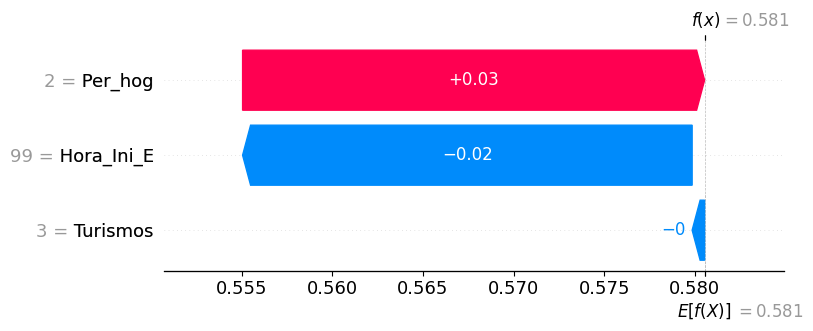

In [181]:
import shap
import matplotlib.pyplot as plt

# Assuming 'explainer' and 'X_train' are already defined and used as shown:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# Select SHAP values for the first sample and a specific class
sample_index = 0
class_index = 0  # Adjust based on the class of interest

selected_shap_values = shap_values.values[sample_index, class_index, :]
selected_feature_values = X_train.iloc[sample_index]
base_value = shap_values.base_values[sample_index, class_index]

# Create a waterfall plot for the selected instance and class
# Set max_display to the number of features you want to show
shap.plots.waterfall(shap.Explanation(values=selected_shap_values,
                                      base_values=base_value,
                                      data=selected_feature_values,
                                      feature_names=X_train.columns.tolist()),
                     max_display=11)  # Adjust this to show more features


In [68]:
X_test

,Hora_Ini_E,Per_hog,Turismos,Sexo,Edad,crnt_tur,drive_tt,distance,walk_tt,transit_tt_gm,Tipo_familia
4,106,2,1,1,5,1,1.725333,768.076,12.326833,11.0,2
5,103,1,1,1,6,1,9.499783,5877.712,81.831450,32.0,3
7,107,2,2,1,4,1,9.773567,6011.384,83.032533,28.0,6
12,118,2,2,2,6,2,9.331617,4642.410,76.662717,26.0,3
13,111,1,3,2,4,1,1.240750,583.437,9.058750,12.0,3
...,...,...,...,...,...,...,...,...,...,...,...
10307,77,2,1,1,4,2,1.916683,1022.297,14.144733,16.0,2
10312,109,3,3,2,5,1,1.435050,648.794,7.445583,9.0,4
10313,83,2,1,1,4,2,2.604183,1240.299,15.294017,18.0,2
10316,93,1,1,1,2,2,1.938700,862.164,14.051100,18.0,2


In [176]:
shap.plots.waterfall(shap_values[0])

TypeError: only length-1 arrays can be converted to Python scalars

In [160]:
X_test

,Hora_Ini_E,Per_hog,Turismos,Sexo,Edad,crnt_tur,drive_tt,distance,walk_tt,transit_tt_gm,Tipo_familia
9250,166,2,3,1,5,1,14.547600,14529.653,225.481133,51.0,4
1217,102,2,2,1,6,1,14.115783,7433.069,79.716333,59.0,4
2227,94,2,1,2,4,2,1.472300,588.940,10.074150,8.0,2
6202,67,2,4,1,2,1,9.977433,7879.266,122.603800,44.0,6
96,82,2,2,2,5,1,4.459133,1848.681,30.184000,15.0,4
...,...,...,...,...,...,...,...,...,...,...,...
5727,185,3,3,1,4,1,3.716700,1486.721,25.044983,11.0,2
1467,194,2,2,2,4,1,2.907483,1222.582,20.605767,18.0,2
7372,154,2,2,1,6,1,27.476900,29412.736,502.904367,92.0,2
9658,98,2,1,2,4,2,2.241333,1026.332,17.077867,16.0,4


In [ ]:
import shap
import matplotlib.pyplot as plt
shap_values = explainer.shap_values(X_test)
# Genera el gráfico de resumen
shap.summary_plot(shap_values[0], X_test, show=False)
# Ajusta el tamaño de la letra del eje y
plt.gca().tick_params(axis='y', labelsize=7)
# Muestra el gráfico
plt.show()

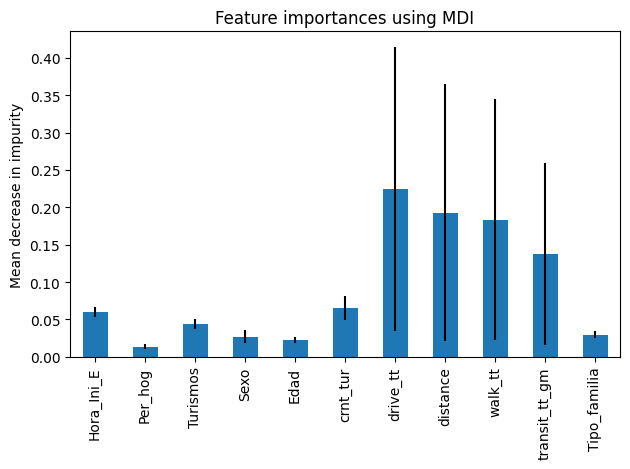

In [165]:
import time
import numpy as np

start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

# print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
import pandas as pd
# forest_importances = pd.Series(importances, index=df_4.drop(columns=['Modo', 'Group']).columns)
columns_to_use = df.drop(columns=["Modo", 'Dur_Tot', "Group", "O_lat", "O_long", "D_lat", "D_long", 'times', 'destination_coords', 'chosen_time', '30%', 'transit_tt', 'gm_ua', "Mun_Ori", "Mun_Des"]).columns
forest_importances = pd.Series(importances, index=columns_to_use)

variables_to_exclude = []

forest_importances = forest_importances.drop(variables_to_exclude)
# filtered_indices = [np.where(columns_to_use == feature)[0][0] for feature in forest_importances.index]

# Now, use these filtered indices to select the matching elements from the std array
# std_filtered = std[filtered_indices]

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()